In [1]:
# !pip install faiss-cpu
# # !pip install clip
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
from torchvision import datasets, transforms, models
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
import clip
import os
from tqdm import tqdm
import faiss
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

In [3]:
train_image_dir = "dataset\\train" # path to train images
test_image_dir = "dataset\\test" # path to test images

In [4]:
def load_and_preprocess_images(image_dir):
    images = []
    filenames = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(("jpg", "jpeg", "png")):
                image_path = os.path.join(root, file)
                image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
                images.append(image)
                filenames.append(image_path)
                
    return image, np.array(filenames)

In [5]:
def extract_features(images):
    with torch.no_grad():
        image_features = []
        for image in tqdm(images, desc="Extracting features"):
            features = model.encode_image(image)
            image_features.append(features)
            
    return torch.cat(image_features).cpu().numpy()

In [6]:
train_images, train_filenames = load_and_preprocess_images(train_image_dir)
test_images, test_filenames = load_and_preprocess_images(test_image_dir)

In [7]:
# train_features = extract_features(train_images)
# test_features = extract_features(test_images)
test_labels = []
for name in test_filenames:
    test_labels.append(name.split('\\')[-2])
train_labels = []
for name in train_filenames:
    train_labels.append(name.split('\\')[-2])

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)

In [8]:
onehot_encoder = OneHotEncoder()
train_labels = onehot_encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels = onehot_encoder.fit_transform(test_labels.reshape(-1, 1))

In [9]:
# np.save("train_features.npy", train_features)
# np.save("test_features.npy", test_features)
train_features = np.load("train_features.npy")
test_features = np.load("test_features.npy")

train_data = [(feature, label) for feature, label in zip(train_features, train_labels)]
# test_data = [(feature, label) for feature, label in zip(test_features, test_labels)]

# print(train_data)
# print(test_data)

In [10]:
index = faiss.IndexFlatL2(test_features.shape[1])
# index = faiss.IndexFlatIP(test_features.shape[1])
index.add(test_features)

In [11]:
def query_image(query_feature, k=100):
    distances, indices = index.search(query_feature, k)
    return indices[0], distances[0]

# def query_image(query_feature, query_index, threshold=200):
#     distances, indices = index.search(query_feature, index.ntotal)
#     filtered_indices = [idx for i, idx in enumerate(indices[0]) if distances[0][i] < threshold and idx != query_index]
#     filtered_distances = [dist for i, dist in enumerate(distances[0]) if distances[0][i] < threshold and indices[0][i] != query_index]
#     return filtered_indices, filtered_distances


In [12]:
def plot_result(query_image, candidates_idx, candidates_path):
    plt.figure(figsize=(20,10))
    columns = 5
    # show query image
    image = Image.open(query_image)
    image = np.asarray(image)
    ax = plt.subplot(3, columns, 1)
    ax.set_title(f"Query: {query_image.split('/')[-1]}")
    plt.imshow(image)
    for i, idx in enumerate(candidates_idx):
        image_path = candidates_path[idx]
        image = Image.open(image_path)
        image = np.asarray(image)
        ax = plt.subplot(3, columns, i + 1 + 5)
        ax.set_title(image_path.split("\\")[-1])
        plt.imshow(image)   
    plt.show()

In [13]:
def calculate_recall_precision(retrieved, retrieved_indices, query_label, num_relevent):
    # true_positive = sum(1 for idx in retrieved_indices if true_labels[idx] == query_label)
    true_positive = 0
    for tl in retrieved:
        if tl == query_label:
            true_positive += 1
    retrieved_count = len(retrieved_indices)
    actual_positive = num_relevent
    precision = true_positive / retrieved_count if retrieved_count else 0
    recall = true_positive / actual_positive if actual_positive else 0
    
    return recall, precision

In [14]:
class CLIPFineTune(nn.Module):
    def __init__(self, output_dim, num_classes):
        super(CLIPFineTune, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(output_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, features):
        logits = self.classifier(features)
        
        return logits

In [15]:
def train_model(train_features, train_labels, output_dim, num_classes, num_epochs=3, learning_rate=5e-5):
    model = CLIPFineTune(output_dim=output_dim, num_classes=num_classes).to(device).to(torch.float32)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = CrossEntropyLoss()

    train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels.toarray(), dtype=torch.float32).to(device) 

    assert train_features.size(0) == train_labels.size(0), "Features and labels must have the same number of samples"

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i in tqdm(range(len(train_features)), desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()
            features = train_features[i].unsqueeze(0)
            labels = train_labels[i].unsqueeze(0)
            logits = model(features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_features)}")
    return model


In [16]:
def get_clip_output_dim(clip_model):
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        features = clip_model.encode_image(dummy_input)
    return features.shape[1]

clip_output_dim = get_clip_output_dim(model)
print(clip_output_dim)

768


c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [17]:
num_classes = 10
num_epochs = 30
learning_rate = 5e-5
fine_tuned_model = CLIPFineTune(clip_output_dim, num_classes).to(device)
fine_tuned_model.load_state_dict(torch.load('fine_tuned_model.pth'))

<All keys matched successfully>

In [17]:
fine_tuned_model = train_model(train_features, train_labels, clip_output_dim, num_classes, num_epochs, learning_rate)
# fine_tuned_model = train_model(train_features, train_labels, model, num_classes, num_epochs, learning_rate)

Training Epoch 1/30: 100%|██████████| 10000/10000 [00:20<00:00, 489.63it/s]


Epoch 1/30, Loss: 0.14857994951448053


Training Epoch 2/30: 100%|██████████| 10000/10000 [00:17<00:00, 586.79it/s]


Epoch 2/30, Loss: 0.015941599699166


Training Epoch 3/30: 100%|██████████| 10000/10000 [00:17<00:00, 584.50it/s]


Epoch 3/30, Loss: 0.008033800319874683


Training Epoch 4/30: 100%|██████████| 10000/10000 [00:17<00:00, 587.16it/s]


Epoch 4/30, Loss: 0.005890630521635006


Training Epoch 5/30: 100%|██████████| 10000/10000 [00:16<00:00, 595.93it/s]


Epoch 5/30, Loss: 0.004690714450725448


Training Epoch 6/30: 100%|██████████| 10000/10000 [00:16<00:00, 595.32it/s]


Epoch 6/30, Loss: 0.0037361522898038645


Training Epoch 7/30: 100%|██████████| 10000/10000 [00:17<00:00, 585.45it/s]


Epoch 7/30, Loss: 0.0030109572407468156


Training Epoch 8/30: 100%|██████████| 10000/10000 [00:16<00:00, 599.09it/s]


Epoch 8/30, Loss: 0.0024504060913971394


Training Epoch 9/30: 100%|██████████| 10000/10000 [00:16<00:00, 608.47it/s]


Epoch 9/30, Loss: 0.0021900409558882885


Training Epoch 10/30: 100%|██████████| 10000/10000 [00:16<00:00, 598.88it/s]


Epoch 10/30, Loss: 0.002087839311017926


Training Epoch 11/30: 100%|██████████| 10000/10000 [00:17<00:00, 584.84it/s]


Epoch 11/30, Loss: 0.0019805992442457616


Training Epoch 12/30: 100%|██████████| 10000/10000 [00:16<00:00, 596.80it/s]


Epoch 12/30, Loss: 0.0018799562736885925


Training Epoch 13/30: 100%|██████████| 10000/10000 [00:17<00:00, 565.17it/s]


Epoch 13/30, Loss: 0.0017552701529553638


Training Epoch 14/30: 100%|██████████| 10000/10000 [00:17<00:00, 563.88it/s]


Epoch 14/30, Loss: 0.001623166981958603


Training Epoch 15/30: 100%|██████████| 10000/10000 [00:16<00:00, 597.62it/s]


Epoch 15/30, Loss: 0.0015042362483196805


Training Epoch 16/30: 100%|██████████| 10000/10000 [00:17<00:00, 569.81it/s]


Epoch 16/30, Loss: 0.0014065350787276934


Training Epoch 17/30: 100%|██████████| 10000/10000 [00:17<00:00, 584.03it/s]


Epoch 17/30, Loss: 0.0013454341473220944


Training Epoch 18/30: 100%|██████████| 10000/10000 [00:17<00:00, 580.35it/s]


Epoch 18/30, Loss: 0.0012247306349449005


Training Epoch 19/30: 100%|██████████| 10000/10000 [00:16<00:00, 603.08it/s]


Epoch 19/30, Loss: 0.001149870440471541


Training Epoch 20/30: 100%|██████████| 10000/10000 [00:16<00:00, 593.52it/s]


Epoch 20/30, Loss: 0.0010577980459309131


Training Epoch 21/30: 100%|██████████| 10000/10000 [00:16<00:00, 603.83it/s]


Epoch 21/30, Loss: 0.0009636714418018329


Training Epoch 22/30: 100%|██████████| 10000/10000 [00:17<00:00, 586.77it/s]


Epoch 22/30, Loss: 0.0008910420543258041


Training Epoch 23/30: 100%|██████████| 10000/10000 [00:16<00:00, 606.23it/s]


Epoch 23/30, Loss: 0.0007992169060388775


Training Epoch 24/30: 100%|██████████| 10000/10000 [00:16<00:00, 623.42it/s]


Epoch 24/30, Loss: 0.0007076111853964456


Training Epoch 25/30: 100%|██████████| 10000/10000 [00:16<00:00, 622.72it/s]


Epoch 25/30, Loss: 0.0006291566239081597


Training Epoch 26/30: 100%|██████████| 10000/10000 [00:16<00:00, 623.81it/s]


Epoch 26/30, Loss: 0.0005427572014125218


Training Epoch 27/30: 100%|██████████| 10000/10000 [00:15<00:00, 625.54it/s]


Epoch 27/30, Loss: 0.0004653094846820423


Training Epoch 28/30: 100%|██████████| 10000/10000 [00:16<00:00, 621.33it/s]


Epoch 28/30, Loss: 0.0003779286026615324


Training Epoch 29/30: 100%|██████████| 10000/10000 [00:19<00:00, 523.60it/s]


Epoch 29/30, Loss: 0.0003152595768757216


Training Epoch 30/30: 100%|██████████| 10000/10000 [00:17<00:00, 570.83it/s]

Epoch 30/30, Loss: 0.0002467259474221933


In [22]:
torch.save(fine_tuned_model.state_dict(), 'fine_tuned_model.pth')

In [18]:
def predict_all(model, test_features, test_labels):
    all_preds = []
    all_labels = []

    test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
    test_labels = torch.tensor(test_labels.toarray(), dtype=torch.float32).to(device)

    assert test_features.size(0) == test_labels.size(0), "Features and labels must have the same number of samples"

    with torch.no_grad():
        for i in tqdm(range(len(test_features)), desc="Predicting"):
            features = test_features[i].unsqueeze(0)
            labels = test_labels[i].unsqueeze(0)
            logits = model(features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [19]:
def query_predict(features, all_preds):
    k_nearest_indices, _ = query_image(features.reshape(1, -1), k=10)
    k_nearest_preds = all_preds[k_nearest_indices]
    majority_vote = Counter(k_nearest_preds).most_common(1)[0][0]
    
    return majority_vote

In [20]:
def evaluate_all(test_features, all_preds, all_labels):    
    total_precision = 0
    total_recall = 0
    for i in tqdm(range(len(all_preds)), desc='Evaluating'):
        pred = query_predict(test_features[i], all_preds)
        # pred = all_preds[i]
        same_class_indices = np.argwhere(all_preds == pred).flatten()
        B = len(same_class_indices)  # Number of total retrieved images
        A = np.sum(all_labels[same_class_indices] == all_labels[i])  # Number of relevant retrieved images
        C = 100
        total_precision += A / B if B > 0 else 0
        total_recall += A / C
        
    precision = total_precision / len(all_preds)
    recall = total_recall / len(all_preds)
    accuracy = 2 * (precision * recall) / (precision + recall)
    
    print(f"Validation Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    
    return accuracy, precision, recall, all_preds

In [21]:
all_preds, all_labels = predict_all(fine_tuned_model, test_features, test_labels)
accuracy, precision, recall, all_preds = evaluate_all(test_features, all_preds, all_labels)

Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 5478.13it/s]

Validation Accuracy: 0.9871747367098773
Precision: 0.9872995049504981
Recall: 0.9870500000000065


In [22]:
def inference(feature, all_preds):
    k = 10
    nearest_indices, distance = query_image(feature.reshape(1, -1), k=100)
    k_nearest_preds = all_preds[nearest_indices[:k]]
    pred_class = Counter(k_nearest_preds).most_common(1)[0][0]
    
    output = nearest_indices[all_preds[nearest_indices] == pred_class][1:k+1]
    
    return output

In [23]:
def evaluate_precision(test_features, all_preds, all_labels, filenames):
    total_precision = 0
    for i in range(0, 1000, 100):
        random_index = np.random.randint(i, i+100)
        now_label = all_labels[random_index]
        output = inference(test_features[random_index], all_preds)
        # output, _ = query_image(test_features[random_index].reshape(1, -1), k=10)
        retrieval_labels = all_labels[output]
        precision = np.sum(retrieval_labels == now_label) / len(retrieval_labels)
        total_precision += precision
        print(filenames[random_index].split('\\')[-2], f"precision: {precision}")
    
    avg_precision = total_precision / 10
    print("Avg Precision:", avg_precision)

In [29]:
evaluate_precision(test_features, all_preds, all_labels, test_filenames)

butterfly precision: 1.0
cat precision: 0.8
chicken precision: 1.0
cow precision: 1.0
dog precision: 0.9
elephant precision: 1.0
horse precision: 1.0
sheep precision: 1.0
spider precision: 1.0
squirrel precision: 1.0
Avg Precision: 0.97


In [35]:
for i in range(1000):
    query_index = i
    print(f"Query Image: {test_filenames[query_index]}")
    output = inference(test_features[query_index], all_preds)
    retrieval = test_filenames[output]
    print(retrieval)

Query Image: dataset\test\butterfly\1001.jpg
['dataset\\test\\butterfly\\1062.jpg' 'dataset\\test\\butterfly\\1026.jpg'
 'dataset\\test\\butterfly\\1075.jpg' 'dataset\\test\\butterfly\\1038.jpg'
 'dataset\\test\\butterfly\\1018.jpg' 'dataset\\test\\butterfly\\1028.jpg'
 'dataset\\test\\butterfly\\1023.jpg' 'dataset\\test\\butterfly\\1086.jpg'
 'dataset\\test\\butterfly\\1079.jpg' 'dataset\\test\\butterfly\\1090.jpg']
Query Image: dataset\test\butterfly\1002.jpg
['dataset\\test\\butterfly\\1100.jpg' 'dataset\\test\\butterfly\\1039.jpg'
 'dataset\\test\\butterfly\\1021.jpg' 'dataset\\test\\butterfly\\1063.jpg'
 'dataset\\test\\butterfly\\1037.jpg' 'dataset\\test\\butterfly\\1040.jpg'
 'dataset\\test\\butterfly\\1086.jpg' 'dataset\\test\\butterfly\\1060.jpg'
 'dataset\\test\\butterfly\\1099.jpg' 'dataset\\test\\butterfly\\1074.jpg']
Query Image: dataset\test\butterfly\1003.jpg
['dataset\\test\\butterfly\\1057.jpg' 'dataset\\test\\butterfly\\1100.jpg'
 'dataset\\test\\butterfly\\1043.jpg' 

Query Image: dataset\test\squirrel\1100.jpg
Retrieved Image 1: dataset\test\squirrel\1062.jpg
Retrieved Image 2: dataset\test\squirrel\1002.jpg
Retrieved Image 3: dataset\test\squirrel\1079.jpg
Retrieved Image 4: dataset\test\squirrel\1018.jpg
Retrieved Image 5: dataset\test\squirrel\1026.jpg
Retrieved Image 6: dataset\test\squirrel\1023.jpg
Retrieved Image 7: dataset\test\squirrel\1057.jpg
Retrieved Image 8: dataset\test\squirrel\1043.jpg
Retrieved Image 9: dataset\test\squirrel\1060.jpg
Retrieved Image 10: dataset\test\squirrel\1039.jpg


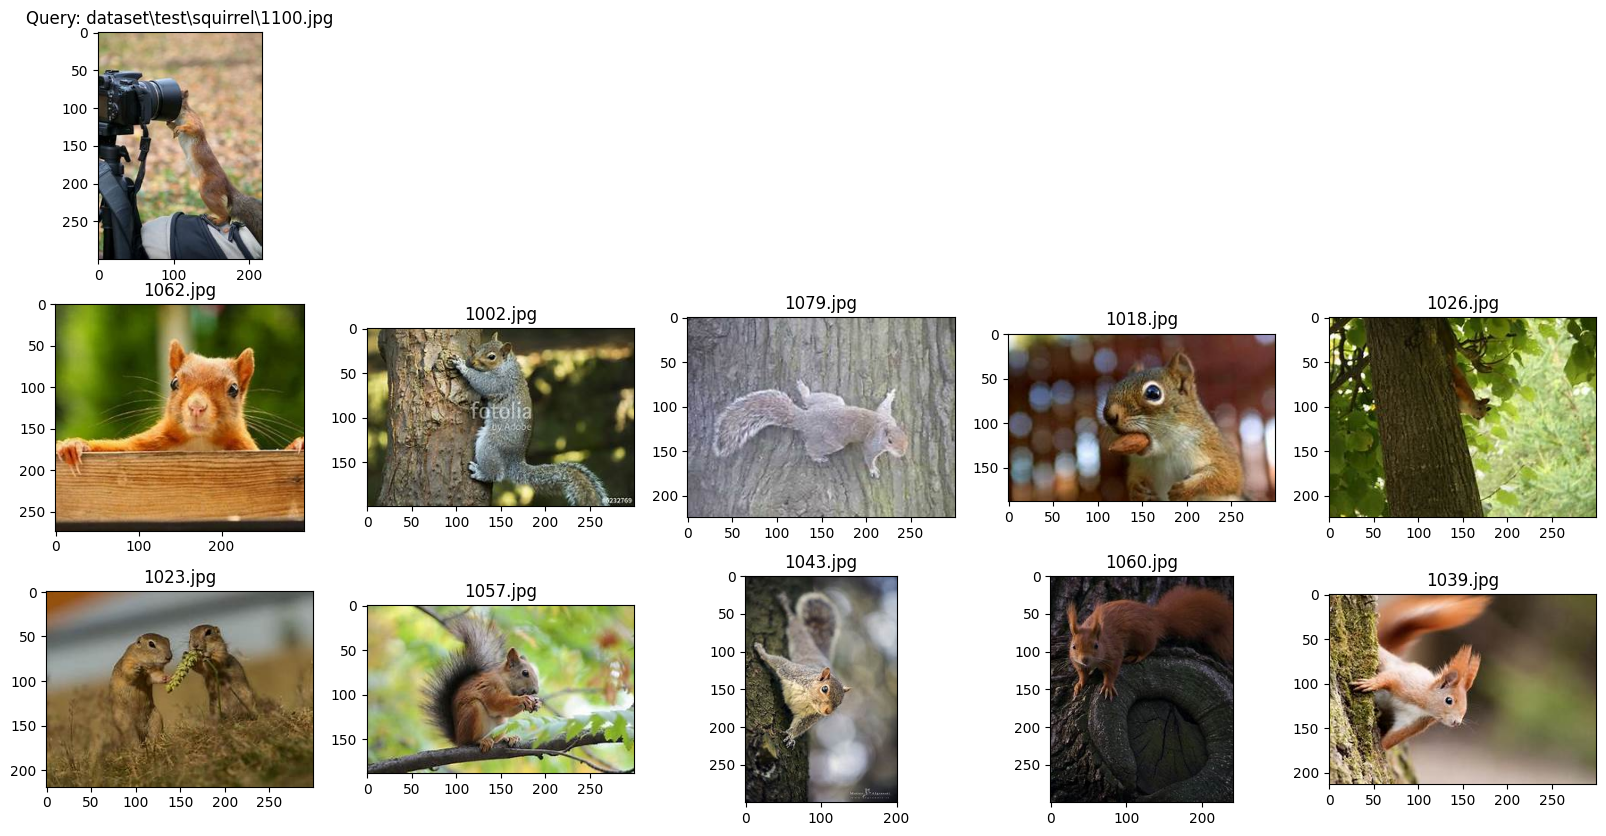

In [40]:
query_index = 999
retrieved_indices = inference(test_features[query_index], all_preds)

print(f"Query Image: {test_filenames[query_index]}")
true_labels = []
for i, idx in enumerate(retrieved_indices):
    print(f"Retrieved Image {i+1}: {test_filenames[idx]}")
    true_labels.append(test_filenames[idx].split('\\')[-2])

plot_result(test_filenames[query_index], retrieved_indices, test_filenames)